In [57]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as pls

%matplotlib inline

df = pd.read_csv("nsdata1.txt",  delimiter=r"\s+")

# After inspecting the data, I found that all three files contain different values 
# for the amount of passangers in each train.
# but all 3 files run on the same schedule (time-wise).

# The labels of the cities are:
AMSTERDAM = 1
ROTTERDAM = 2
ROOSENDAAL = 3
VLISSINGEN = 4

train_3 = [38, 163]

df.head(10)

,train_number,from,to,departure_time,arrival_time,first_class,second_class
0,2123,2,3,700,740,4,58
1,2123,3,4,743,838,14,328
2,2127,1,2,648,755,47,340
3,2127,2,3,801,841,35,272
4,2127,3,4,843,938,19,181
5,2131,1,2,755,858,100,616
6,2131,2,3,902,941,52,396
7,2131,3,4,943,1038,27,270
8,2135,1,2,856,958,61,407
9,2135,2,3,1003,1043,41,364


In [58]:
def to_minutes_past_midnight(time: int) -> int:
    """
    Converts the time as used in the data-files to minutes past midnight.
    """

    assert type(time) == int, "The time must be an integer!"

    hours = time // 100
    minutes = time % 100

    return 60*hours + minutes

In [59]:
df['departure_time'] = df['departure_time'].map(lambda x: to_minutes_past_midnight(x))
df['arrival_time'] = df['arrival_time'].map(lambda x: to_minutes_past_midnight(x))

In [60]:
df.head(10)

,train_number,from,to,departure_time,arrival_time,first_class,second_class
0,2123,2,3,420,460,4,58
1,2123,3,4,463,518,14,328
2,2127,1,2,408,475,47,340
3,2127,2,3,481,521,35,272
4,2127,3,4,523,578,19,181
5,2131,1,2,475,538,100,616
6,2131,2,3,542,581,52,396
7,2131,3,4,583,638,27,270
8,2135,1,2,536,598,61,407
9,2135,2,3,603,643,41,364


In [61]:
def total_passangers_at_t(passanger_type:str, row:pd.Series)->  int:
    """ 
    Amount of passagers of passanger_type in row.
    passanger_types = ['1', '2']
    """

    first = row[5]
    second = row[6] 

    return (passanger_type=='1')*first + (passanger_type=='2')*second 

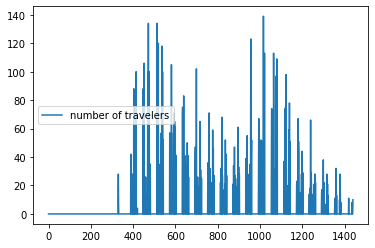

In [65]:
df_travelers_per_minute_first = pd.DataFrame(np.zeros((60*24, 1)))
df_travelers_per_minute_first.columns = ['number of travelers']

for index, row in df.iterrows():
    start = row[3]
    stop = row[4]
    tot = total_passangers_at_t('1', row)
    df_travelers_per_minute_first.loc[[start, stop + 1], 'number of travelers'] += tot

df_travelers_per_minute_first.plot();

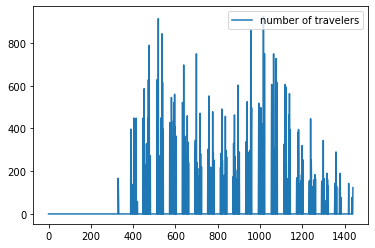

In [66]:
df_travelers_per_minute_second = pd.DataFrame(np.zeros((60*24, 1)))
df_travelers_per_minute_second.columns = ['number of travelers']

for index, row in df.iterrows():
    start = row[3]
    stop = row[4]
    tot = total_passangers_at_t('2', row)
    df_travelers_per_minute_second.loc[[start, stop + 1], 'number of travelers'] += tot

df_travelers_per_minute_second.plot();